# Global Forecasting and Foundation Models

### Overview of this notebook

* Global Forecasting
    * Introduction
    * Example with/without exogenous data
    * Global Forecasters in sktime
* Foundation Models
    * Introduction
    * Examples
    * Training Methods
    * License Management
    * Foundation Models for Global Forecasting
* Recap
* Credits

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Global Forecasting

global forecasting = (pre-)training model on examples, to later forecast

Common examples:

* transformer based deep learning forecasters, pre-training and fine-tuning
* reduction forecasters with sklearn regressors trained on larger sample

<img src="./img/global-fcst.png" alt="Global Forecast" style="width: 100%; max-width: 600px;">

Mathematically, vanilla case:

   - train on dataset containing $n$ time series $y_1(t), y_2(t), \dots, y_N(t)$
   - forecast on another time series $y^*(t)$
       - given $y^*(t_1), \dots, y^*(t_T),$ produce forecasts $y^*(t_T + h_1), \dots, y^*(t_T + h_H)$

basic `sktime` interface for global forecasting:

```python
model.fit(y=y_train, fh=fh)
model.predict(y=y_deploy)  # new time series passed in predict!
```

To search for global forecasters, use the `capability:global_forecasting` tag:

In [2]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingDeepAR

PytorchForecastingDeepAR().get_tag(
    "capability:global_forecasting"
)  # should return True

True

### Example

The data is from the [Stallion kaggle competition](https://www.kaggle.com/datasets/utathya/future-volume-prediction).

In [3]:
from utils import load_stallion

X, y = load_stallion()

#### Global Forecasting without exogeneous data

First, let's try to fit and predict without exogeneous data

In [4]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9], is_relative=True, freq="MS")

from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(y, test_size=0.1, train_size=0.9, shuffle=False)
y_true = y_test.groupby(level=[0,1]).apply(lambda x: x.droplevel([0,1]).iloc[-max(fh):])
y_test = y_test.groupby(level=[0,1]).apply(lambda x: x.droplevel([0,1]).iloc[:-max(fh)])

`y_train` is the series we want to fit on which contains the first 90% of the time series instances.

In [5]:
y_train

volume
agency    sku    date                  
Agency_01 SKU_01 2013-01-01    80.67600
                 2013-02-01    98.06400
                 2013-03-01   133.70400
                 2013-04-01   147.31200
                 2013-05-01   175.60800
...                                 ...
Agency_55 SKU_05 2017-08-01  1058.95050
                 2017-09-01   909.68025
                 2017-10-01  1156.84560
                 2017-11-01   902.71500
                 2017-12-01  1202.59800

[18900 rows x 1 columns]

`y_test` is the series we want to predict on which contains the last 10% of the time series instances.

In [6]:
y_test

volume
agency    sku    date                
Agency_56 SKU_01 2013-01-01  2999.160
                 2013-02-01  3541.212
                 2013-03-01  4057.992
                 2013-04-01  4152.276
                 2013-05-01  4885.488
...                               ...
Agency_60 SKU_23 2016-11-01     0.360
                 2016-12-01     3.510
                 2017-01-01     2.160
                 2017-02-01     2.520
                 2017-03-01     1.710

[1785 rows x 1 columns]

You can see that `y_train` and `y_test` are different on hierarchical level which indicates that they come from different instances.

We can initialize a global forecaster to fit on `y_train` and predict on `y_test`.

In [7]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats

model = PytorchForecastingNBeats(
    trainer_params={
        "max_epochs": 10,
    },
)

In [8]:
# This could take 1 min to fit the data
model.fit(y=y_train, fh=fh)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024-08-25 20:28:29.883952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-25 20:28:29.883985: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 1.6 M  | train
-------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.588     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


PytorchForecastingNBeats(trainer_params={'max_epochs': 10})

Then we can predict on `y_test` which is not included in `y_train`.

In [9]:
y_pred = model.predict(y=y_test, fh=fh)
y_pred

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


volume
agency    sku    date                   
Agency_56 SKU_01 2017-04-01  3951.250000
                 2017-05-01  4107.307617
                 2017-06-01  4136.220703
                 2017-07-01  4047.581055
                 2017-08-01  3932.987793
...                                  ...
Agency_60 SKU_23 2017-08-01     1.578460
                 2017-09-01     1.384859
                 2017-10-01     1.282674
                 2017-11-01     1.366856
                 2017-12-01     1.663556

[315 rows x 1 columns]

`y_pred` have the same instance index as `y_test`.

We can plot one series to see the result. As we train the model for a few epochs, we can not expect too much.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='volume'>)

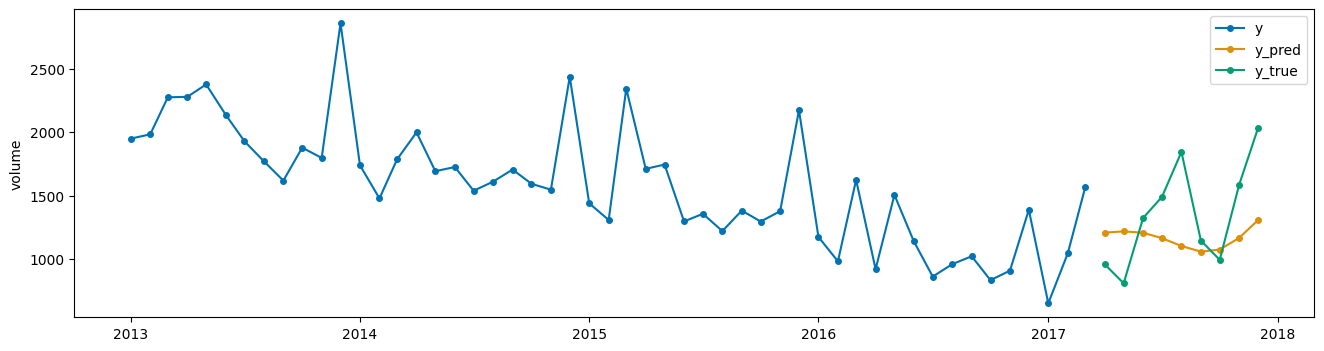

In [10]:
from sktime.utils.plotting import plot_series
ins=("Agency_59","SKU_04")
plot_series(
    y_test.loc[ins],
    y_pred.loc[ins],
    y_true.loc[ins],
    labels=["y", "y_pred", "y_true"],
)

#### Global Forecasting with exogeneous data

Then let's try to fit and predict with exogeneous data

When we predict with exogeneous data, we need to pass both `X` and `y` to `predict`.

`X` must contain all historical values and the time points to be predicted while `y` should only contain the historical values but not the time points to be predicted.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, train_size=0.9, shuffle=False
)
y_true = y_test.groupby(level=[0,1]).apply(lambda x: x.droplevel([0,1]).iloc[-max(fh):])
y_test = y_test.groupby(level=[0,1]).apply(lambda x: x.droplevel([0,1]).iloc[:-max(fh)])

`X_train` and `y_train` have the same time index from 2000-01-01 to 2000-01-10.

However `y_test` is shorter than `X_test`. 

`X_test` has the time index from 2013-01-01 to 2017-12-01 but `y_test` only has the time index from 2013-01-01 to 2017-03-01. 

This is because we don't know the values from 2017-4-01 to 2017-12-01 of `y_test` which are going to be forecasted.

In [12]:
y_test

volume
agency    sku    date                
Agency_56 SKU_01 2013-01-01  2999.160
                 2013-02-01  3541.212
                 2013-03-01  4057.992
                 2013-04-01  4152.276
                 2013-05-01  4885.488
...                               ...
Agency_60 SKU_23 2016-11-01     0.360
                 2016-12-01     3.510
                 2017-01-01     2.160
                 2017-02-01     2.520
                 2017-03-01     1.710

[1785 rows x 1 columns]

In [13]:
# This could take 1 min to fit the data
from sktime.forecasting.pytorchforecasting import PytorchForecastingNHiTS

model = PytorchForecastingNHiTS(
    trainer_params={
        "max_epochs": 10,  # for quick test
    },
)

model.fit(y=y_train, X=X_train, fh=fh)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | MASE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 2.0 M  | train
-----------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.033     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


PytorchForecastingNHiTS(trainer_params={'max_epochs': 10})

Now we can predict on `y_test` with `X_test`.

`y_test` is shorter than `X_test` as `y_test` only contains the historical values not the time points to be predicted.

In [14]:
y_pred = model.predict(fh=fh, X=X_test, y=y_test)
y_pred

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


volume
agency    sku    date                   
Agency_56 SKU_01 2017-04-01  3959.031250
                 2017-05-01  4270.536133
                 2017-06-01  3942.584229
                 2017-07-01  3922.987061
                 2017-08-01  3881.025635
...                                  ...
Agency_60 SKU_23 2017-08-01     0.600497
                 2017-09-01     0.593148
                 2017-10-01     0.558027
                 2017-11-01     1.115644
                 2017-12-01     1.905408

[315 rows x 1 columns]

We can plot one series to see the result. As we train the model for a few epochs, we can not expect too much.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='volume'>)

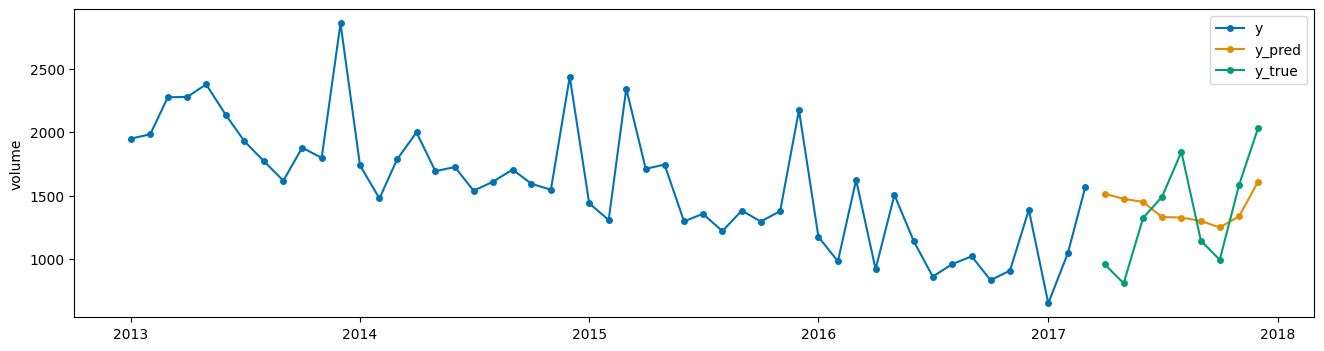

In [15]:
ins=("Agency_59","SKU_04")
plot_series(
    y_test.loc[ins],
    y_pred.loc[ins],
    y_true.loc[ins],
    labels=["y", "y_pred", "y_true"],
)

### Global Forecasters in sktime

List of the global forecasters available in sktime

In [16]:
from sktime.registry import all_estimators

all_estimators(
	"forecaster",
	filter_tags={"capability:global_forecasting": True},
	as_dataframe=True,
)

,name,object
0,AutoRegressiveWrapper,<class 'sktime.forecasting.compose._autoregres...
1,DummyGlobalForecaster,<class 'sktime.forecasting.dummy.DummyGlobalFo...
2,PytorchForecastingDeepAR,<class 'sktime.forecasting.pytorchforecasting....
3,PytorchForecastingNBeats,<class 'sktime.forecasting.pytorchforecasting....
4,PytorchForecastingNHiTS,<class 'sktime.forecasting.pytorchforecasting....
5,PytorchForecastingTFT,<class 'sktime.forecasting.pytorchforecasting....
6,TinyTimeMixerForecaster,<class 'sktime.forecasting.ttm.TinyTimeMixerFo...


More expected models with global forecasting interface in future - [ [ENH] Make forecasters global - Wishlist #6836 ](https://github.com/sktime/sktime/issues/6836)

## Foundation models

**What is a foundation model?**

A foundation model is a large, **pre-trained deep learning model** that serves as a versatile base for various downstream tasks.

Typically:
* uses "transformer" or other advanced deep learning architecture
* weights need to be downloaded and handled
* 2024 state: model code not easily installable!
    * most models have no proper package releases
    * heavy or conflicted dependency sets
    * commercial open source with "lock-in" or "lock-down" flavour

`sktime`-less users need to manage:
* **model code**, e.g., source installation
* **model code dependencies**, python packages
* **weights**, e.g., .pkl, .pt, .bin, .h5 files
* **weight dependencies**, python packages

`sktime` API abstracts this away and manages on framework level

<img src="./img/fm-simple.png" alt="Foundation Model Overview" style="width: 100%; max-width: 600px;">

### Examples

In [17]:
from sktime.datasets import load_airline

# Load the dataset for example
y = load_airline()

In [18]:
# keep same prediction length for all examples
pred_len = 16

In [19]:
# import plotting function
from sktime.utils.plotting import plot_series

#### Informer

A model designed for efficient long-term time series forecasting. It uses self-attention mechanisms with a sparse operation to reduce the computational complexity, making it suitable for handling large-scale data.

In [20]:
from sktime.forecasting.hf_transformers_forecaster import HFTransformersForecaster

forecaster = HFTransformersForecaster(
    model_path = "huggingface/informer-tourism-monthly",
    fit_strategy = "minimal",
    training_args = {
        "num_train_epochs": 100,
        "output_dir": "test_output",
        "per_device_train_batch_size": 32,
        "report_to": "none",
    },
    config = {
        "lags_sequence": [1, 2, 3],
        "context_length": 8,
        "prediction_length": pred_len,
        "use_cpu": True,
        "label_length": 8,
    },
    deterministic = True,
)
forecaster.fit(y, fh=list(range(1, pred_len+1)))
y_pred = forecaster.predict()

Some weights of the model checkpoint at huggingface/informer-tourism-monthly were not used when initializing InformerForPrediction: ['model.embedder.embedders.0.weight']
- This IS expected if you are initializing InformerForPrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing InformerForPrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of InformerForPrediction were not initialized from the model checkpoint at huggingface/informer-tourism-monthly and are newly initialized because the shapes did not match:
- model.encoder.value_embedding.value_projection.weight: found shape torch.Size([32, 22]) in the checkpoint and torch.Size([32, 5]) in the model instantiated
- model.en

  0%|          | 0/300 [00:00<?, ?it/s]

{'train_runtime': 20.2568, 'train_samples_per_second': 434.421, 'train_steps_per_second': 14.81, 'train_loss': 6.553369954427083, 'epoch': 100.0}


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

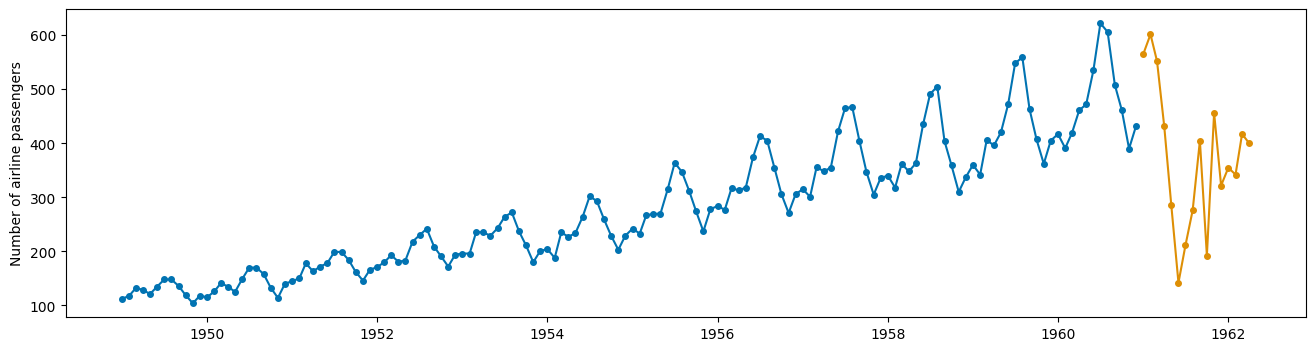

In [21]:
plot_series(y, y_pred)

#### Autoformer

A deep learning model that focuses on improving time series forecasting by automatically learning seasonal-trend decomposition. It leverages attention mechanisms to capture long-range dependencies in the data.

In [22]:
from sktime.forecasting.hf_transformers_forecaster import HFTransformersForecaster

forecaster = HFTransformersForecaster(
    model_path = "huggingface/autoformer-tourism-monthly",
    fit_strategy = "minimal",
    training_args = {
        "num_train_epochs": 20,
        "output_dir": "test_output",
        "per_device_train_batch_size": 32,
        "report_to": "none",
    },
    config = {
        "lags_sequence": [1, 2, 3],
        "context_length": 8,
        "prediction_length": pred_len,
        "use_cpu": True,
        "label_length": 8,
    },
    deterministic = True,
)
forecaster.fit(y, fh=list(range(1, pred_len+1)))
y_pred = forecaster.predict()

Some weights of the model checkpoint at huggingface/autoformer-tourism-monthly were not used when initializing AutoformerForPrediction: ['model.embedder.embedders.0.weight']
- This IS expected if you are initializing AutoformerForPrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AutoformerForPrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AutoformerForPrediction were not initialized from the model checkpoint at huggingface/autoformer-tourism-monthly and are newly initialized because the shapes did not match:
- model.encoder.value_embedding.value_projection.weight: found shape torch.Size([64, 22]) in the checkpoint and torch.Size([64, 5]) in the model instantiate

  0%|          | 0/60 [00:00<?, ?it/s]

{'train_runtime': 12.0108, 'train_samples_per_second': 146.535, 'train_steps_per_second': 4.996, 'train_loss': 7.186167907714844, 'epoch': 20.0}


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

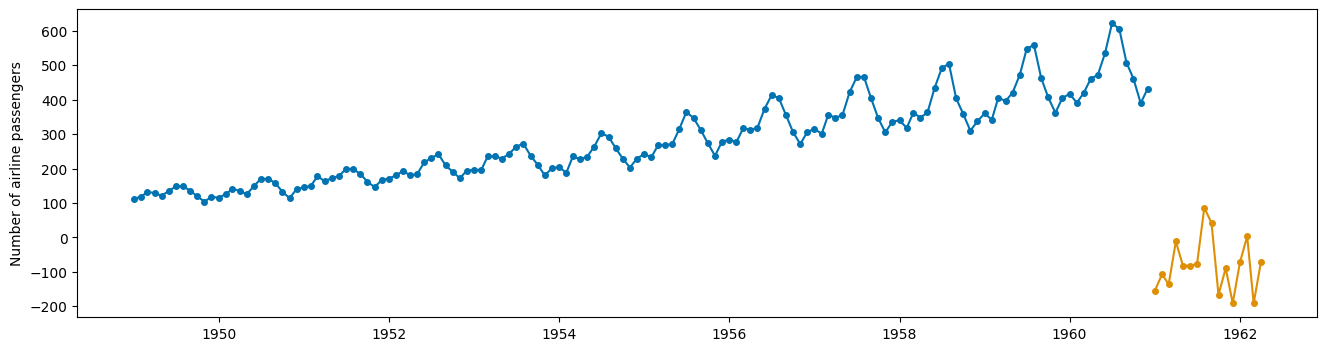

In [23]:
plot_series(y, y_pred)

#### TinyTimeMixer

A lightweight model for time series forecasting, designed to be computationally efficient while maintaining strong predictive performance. It uses a mixing architecture to combine different time-series features.

In [24]:
from sktime.forecasting.ttm import TinyTimeMixerForecaster
from sktime.datasets import load_airline

y = load_airline()

forecaster = TinyTimeMixerForecaster(
    config={
        "context_length": 20,
        "prediction_length": 10,
    },
    training_args={
        "num_train_epochs": 100,
        "output_dir": "test_output",
        "per_device_train_batch_size": 32,
        "report_to": "none",
        "learning_rate": 1e-2,
    },
)
forecaster.fit(y, fh=list(range(1, pred_len+1)))
y_pred = forecaster.predict()

Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm/TTM and are newly initialized because the shapes did not match:
- backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.patch_mixer.gating_block.attn_layer.bias: found shape torch.Size([32]) in the checkpoint and torch.Size([40]) in the model instantiated
- backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.patch_mixer.gating_block.attn_layer.weight: found shape torch.Size([32, 32]) in the checkpoint and torch.Size([40, 40]) in the model instantiated
- backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.patch_mixer.mlp.fc1.bias: found shape torch.Size([64]) in the checkpoint and torch.Size([80]) in the model instantiated
- backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.patch_mixer.mlp.fc1.weight: found shape torch.Size([64, 32]) in the checkpoint and torch.Size([80, 40]) in the model instantiated
- backbone.encoder.mlp_mixer_encoder.mixers.0.mixer_layers.0.pa

  0%|          | 0/300 [00:00<?, ?it/s]

{'train_runtime': 24.8902, 'train_samples_per_second': 321.411, 'train_steps_per_second': 12.053, 'train_loss': 170.57397135416667, 'epoch': 100.0}


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

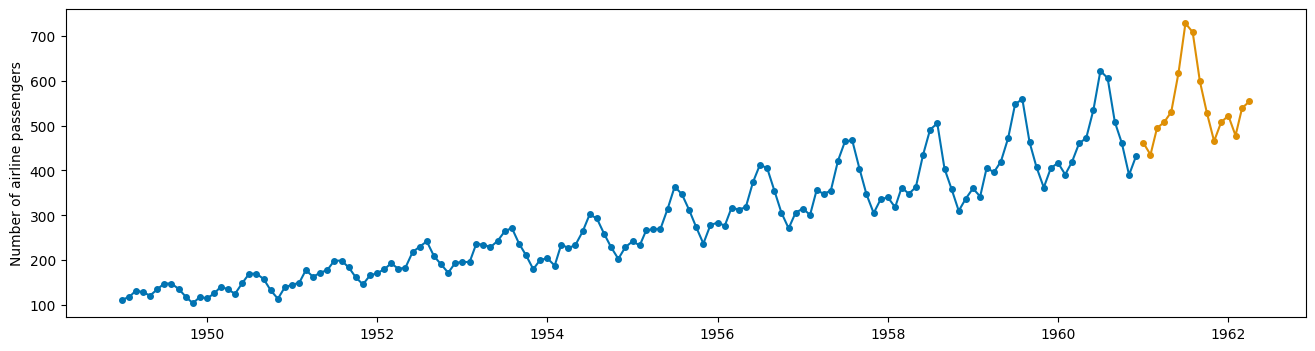

In [25]:
plot_series(y, y_pred)

#### PEFT Models

`HFTransformersForecaster` supports Parameter-Efficient Fine-Tuning (PEFT) methods.
 training, but we are developing a unified interface to apply peft on deep learning foundation models

To follow or participate in the discussion, refer to the relevant issue: [#6968](https://github.com/sktime/sktime/issues/6968)

In [26]:
# Make sure you have peft library installed
# !pip install peft

In [27]:
from sktime.forecasting.hf_transformers_forecaster import HFTransformersForecaster
from peft import LoraConfig

forecaster = HFTransformersForecaster(
    model_path = "huggingface/informer-tourism-monthly",
    fit_strategy = "minimal",
    training_args = {
        "num_train_epochs": 100,
        "output_dir": "test_output",
        "per_device_train_batch_size": 32,
        "report_to": "none",
    },
    config = {
        "lags_sequence": [1, 2, 3],
        "context_length": 8,
        "prediction_length": pred_len,
        "use_cpu": True,
        "label_length": 8,
    },
    deterministic = True,
    peft_config=LoraConfig(
        r=8,
        lora_alpha=32,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.01,
    )
)
forecaster.fit(y, fh=list(range(1, pred_len+1)))
y_pred = forecaster.predict()

Some weights of the model checkpoint at huggingface/informer-tourism-monthly were not used when initializing InformerForPrediction: ['model.embedder.embedders.0.weight']
- This IS expected if you are initializing InformerForPrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing InformerForPrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of InformerForPrediction were not initialized from the model checkpoint at huggingface/informer-tourism-monthly and are newly initialized because the shapes did not match:
- model.encoder.value_embedding.value_projection.weight: found shape torch.Size([32, 22]) in the checkpoint and torch.Size([32, 5]) in the model instantiated
- model.en

  0%|          | 0/300 [00:00<?, ?it/s]

{'train_runtime': 21.0779, 'train_samples_per_second': 417.498, 'train_steps_per_second': 14.233, 'train_loss': 6.503758138020833, 'epoch': 100.0}


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

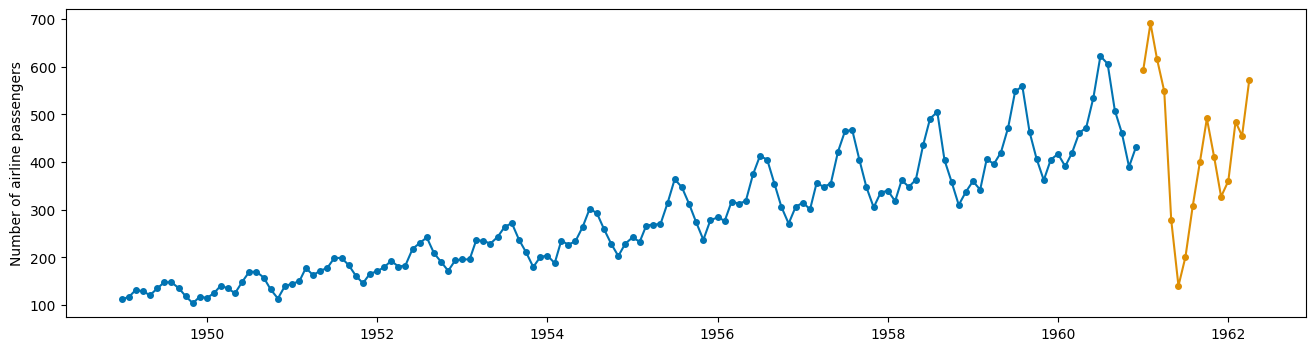

In [28]:
plot_series(y, y_pred)

More Foundation Models to come in future - [#6177](https://github.com/sktime/sktime/issues/6177)

Here are a few foundation models in progress 
| Foundation Model  | Pull Request                                    | Contributor                  |
|-------------------|-------------------------------------------------|------------------------------|
| Amazon Chronos    | [PR #6665](https://github.com/sktime/sktime/pull/6665) | [Z-Fran](https://github.com/Z-Fran)         |
| LagLlama          | [PR #6659](https://github.com/sktime/sktime/pull/6659) | [shlok191](https://github.com/shlok191)     |
| MOIRAI            | [PR #6299](https://github.com/sktime/sktime/pull/6299) | [pranavvp16](https://github.com/pranavvp16) |
| TimesFM           | [PR #6571](https://github.com/sktime/sktime/pull/6571) | [geetu040](https://github.com/geetu040)     |
| MomentFM          | [PR #6570](https://github.com/sktime/sktime/pull/6570) | [julian-fong](https://github.com/julian-fong) |


### Training

Foundation models in sktime can internally perform zero-shot forecasting or be fine-tuned based on how, and with what arguments they are initialized.

The model is initialized with weights downloaded and cached from the specified `model_path` on Hugging Face. Depending on the model's configuration, additional steps may occur:

* **Additional Weights**: Added if the model requires extra layers, such as a classification head, for a downstream task.
* **Re-initialized Weights**: Occur when the model's configuration differs from the default available on Hugging Face.

As a result, the model may contain a mix of original and newly initialized weights. You can choose from the following training options:

* **Fine-tuning / Full-training**: Train all the model's weights.
* **PEFT Training**: Train a small subset of weights, determined by the PEFT method and configuration.
* **Minimal Training**: Train only the newly initialized weights. If there are no newly initialized weights, there is no training and thus performs zero-shot forecasting.

The availability of these training options through the estimator's interface, either via parameters or inferred internally, depends on the estimator and is documented in the docstring.
* **HFTransformersForecaster:** support all 3 training scenarios
* **TinyTimeMixer:** supports only minimal training


### License Management

**Foundation Model Artifacts**

- defined model architechture
- pre-trained weights

caveat: different parts may come with different license!

* `sktime` framework layer always permissinve - BSD-3 clause
* weights - inspect huggingface tag or original release; also check docstring
* model code - `license_type` tag in `sktime` if populated; docstring

<img src="./img/fm-license.png" alt="Foundation Model Overview" style="width: 100%; max-width: 600px;">

Example: silent change in MOIRAI foundation model weights license from permissive to non-commercial.

Auto-upgrade to newest commit without version bounds creates a license violation in commercial deployment!

**Sktime Vendor Fork**

sktime may fork some code from the official source because of
* dependency issues
* unavailability on pypi
* license change

This forked code goes into [`sktime/libs`](TODO), and the license attached with the official code is kept as is in the fork

Source installation can be selected via `use_source_package` parameter

**License information given by `sktime` includes third-party license tags,
provided as-is without any warranties or liability.**

**Users are responsible for ensuring compliance with applicable licenses
and verifying the accuracy of the license information.**

### Foundation Models for Global Forecasting

Intuitively Foundation Models can perform Global Forecasting

Currently, `TinyTimeMixerForecaster` is the only foundation model that supports global forecasting

We are expecting to extend more existing foundation models with global forecasting capablity.

To see the wishlist on make forecasters global, you can follow the discussion here - [#6836](https://github.com/sktime/sktime/issues/6836)

## Recap


**Global Forecasting**

* Involves training models on multiple time series to make forecasts on new series.
* Demonstrated with SKU volume prediction using sktime, both with and without exogenous data.

**Foundation Models**

* Large, pre-trained deep learning models designed for versatility across various tasks.
* Showcased models: Informer, Autoformer, and TinyTimeMixer.
* Training Approaches like fine-tuning, minimal training, and PEFT methods.
* License Management with foundation models.
* Foundation Models and Global Forecasting

---
## Credits: notebook 3 - `global forecasting`

notebook creation: xinyu, geetu, fkiraly, felipe

global forecasting interface: xinyu

General credit also to `sklearn` and `sktime` contributors